In [1]:
#Please select GPU first (from Edit->NotebookSetting)
import pandas as pd
import numpy as np
import io
import os
import re
from google.colab import drive
!pip install fastai==2.3.1
from fastai.text.all import *
drive.mount('/content/drive')

     |████████████████████████████████| 204kB 5.3MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/colab_data'
def de_emojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')
def tweet_proc(df, text_col='text'):
    df['orig_text'] = df[text_col]
    # Remove twitter handles
    df[text_col] = df[text_col].apply(lambda x:re.sub('@[^\s]+','',x))
    # Remove URLs
    df[text_col] = df[text_col].apply(lambda x:re.sub(r"http\S+", "", x))
    # Remove emojis
    df[text_col] = df[text_col].apply(de_emojify)
    # Remove hashtags
    df[text_col] = df[text_col].apply(lambda x:re.sub(r'\B#\S+','',x))
    return df[df[text_col]!='']


In [3]:
covid_tweet = pd.read_csv(os.path.join(path, "Covid-19 Twitter Dataset (Aug-Sep 2020).csv"))
covid_tweet = covid_tweet[covid_tweet.original_text.isnull()==False].drop_duplicates().reset_index(drop=True)
covid_tweet = tweet_proc(covid_tweet,'original_text')
covid_tweet['emotion'] = np.nan
covid_tweet = covid_tweet[covid_tweet.lang=='en']
covid_tweet = covid_tweet.rename(columns={'original_text':'text'})
# covid_tweet = covid_tweet.sample(n=40000, random_state=1)
covid_tweet.head(3)

,id,created_at,source,text,lang,favorite_count,retweet_count,original_author,hashtags,user_mentions,place,clean_tweet,compound,neg,neu,pos,sentiment,orig_text,emotion
0,1.300000e+18,Thu Aug 20 08:20:55 +0000 2020,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",RT 91-year-old Ex-Vice President Moody Awori Lands Inter County Covid-19 Committee Role,en,0.0,100.0,kvn_kegan,NaN,RobertAlai,"Nairobi, Kenya",year old ex vice presid moodi awori land inter counti covid19 committe role,0.0000,0.0,1.000,0.000,neu,RT @RobertAlai: 91-year-old Ex-Vice President Moody Awori Lands Inter County Covid-19 Committee Role https://t.co/bslXxeMpGD,NaN
1,1.300000e+18,Thu Aug 20 08:20:54 +0000 2020,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","RT BREAKING: The Department of Health reports 4,339 more people caught COVID-19, pushing the national case count to 178,02",en,0.0,38.0,puTOPinamo,NaN,cnnphilippines,NaN,break depart health report peopl caught covid19 push nation case count,0.0000,0.0,1.000,0.000,neu,"RT @cnnphilippines: BREAKING: The Department of Health reports 4,339 more people caught COVID-19, pushing the national case count to 178,02…",NaN
2,1.300000e+18,Thu Aug 20 08:20:53 +0000 2020,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",RT Helps Out Fan Who Requested Him To Help Arrange A Bed For Her Positive Father (View Tweet)\n,en,0.0,0.0,DevSidheart,"SidharthShukla, Covid_19",latestly,Sidheart,help fan request help arrang bed posit father view tweet,0.7717,0.0,0.476,0.524,pos,RT @latestly: #SidharthShukla Helps Out Fan Who Requested Him To Help Arrange A Bed For Her #Covid_19 Positive Father (View Tweet)\n@sidhart…,NaN


In [4]:
basic_tweet = pd.read_csv(os.path.join(path, "tweet_dataset.csv"))
basic_tweet = basic_tweet[basic_tweet.sentiment!='empty'].drop_duplicates().reset_index(drop=True)
basic_tweet = basic_tweet[['sentiment','old_text']].rename(columns={'old_text':'text', 'sentiment':'emotion'})
basic_tweet = tweet_proc(basic_tweet,'text')
basic_tweet.head(3)

,emotion,text,orig_text
0,sadness,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed with a headache ughhhh...waitin on your call...
1,sadness,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...
2,enthusiasm,wants to hang out with friends SOON!,wants to hang out with friends SOON!


In [5]:
df_lm = basic_tweet[['text', 'emotion']].append(covid_tweet[['text', 'emotion']]) 
df_clas = df_lm[['text', 'emotion']].dropna(subset=['emotion'])
print(len(df_lm), len(df_clas))
df_clas.head(3)

281843 39107


,text,emotion
0,Layin n bed with a headache ughhhh...waitin on your call...,sadness
1,Funeral ceremony...gloomy friday...,sadness
2,wants to hang out with friends SOON!,enthusiasm


In [6]:
dls_lm= torch.load(os.path.join(path, 'dls_lm.pkl'))

In [8]:
dls_clas = DataBlock(
    blocks = (TextBlock.from_df('text', seq_len = dls_lm.seq_len, vocab = dls_lm.vocab), CategoryBlock),
    # blocks = (TextBlock.from_df('text', seq_len = 72, vocab = vocab_list), CategoryBlock),
    get_x = ColReader('text'),
    get_y = ColReader('emotion'),
    splitter = RandomSplitter()
).dataloaders(df_clas, bs = 64)
torch.save(dls_clas, os.path.join(path, 'dls_clas_emo.pkl'))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [7]:
# load file
dls_clas = torch.load(os.path.join(path, 'dls_clas_emo.pkl'))

In [8]:
dls_clas.show_batch(max_n=4)

,text,category
0,xxbos oo ? xxunk ? xxunk ? ? d ? ? ss xxrep 3 ? sn s xxrep 3 ? u xxrep 6 ? xxrep 4 ? ? ' p xxrep 3 ? o ? p xxrep 3 ? ? no ? ? xxunk ? ? q ? xxunk ? u ? ? o ? ? o ? xxrep 4 ? ? oo ? o ? xxrep 4 ? o ? ? sn ?,neutral
1,xxbos xxmaj is xxmaj home xxmaj alone xxmaj yet xxmaj again ; xxmaj mam xxmaj and xxmaj dad xxmaj rather xxmaj go xxmaj to xxmaj the xxmaj club xxmaj than xxmaj stay xxmaj in xxmaj with xxmaj me xxmaj or xxmaj take xxmaj me xxmaj out ; xxmaj yes i xxmaj think xxmaj that xxmaj proves xxmaj how xxmaj loved i xxmaj am !,sadness
2,"xxbos xxup proud 2 xxup be a xxup mother i xxup have xxup my xxup son & & xxup his xxup xxunk xxup over xxup spending a xxup nite , xxup it 's a xxup xxunk xxup nite , & & xxup they xxup driving xxup me xxup crazy xxup but i xxup luv xxup em ..",love
3,"xxbos * * jaw xxmaj drops * * * * gasp * * xxmaj whatever do u mean ? xxmaj i 'm as sweet as pie xxmaj allow me to re - introduce myself , xxmaj i 'm xxmaj coach & & xxmaj i 'm a xxmaj cancer & & u ?",fun


In [10]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [12]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3))
learn.save(os.path.join(path, 'twitter_classifier_emo'))

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,2.056175,1.922950,0.342411,24:29
1,1.890226,1.823931,0.359289,24:22
2,1.805983,1.803869,0.372587,24:18
3,1.780309,1.800979,0.370797,23:12


Path('/content/drive/MyDrive/colab_data/twitter_classifier_emo.pth')

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).load(os.path.join(path, 'twitter_classifier_emo'))

In [10]:
learn.predict("I hate")

('hate',
 tensor(5),
 tensor([0.0037, 0.0054, 0.0028, 0.0060, 0.0036, 0.7061, 0.0138, 0.0230, 0.0029,
         0.1271, 0.0062, 0.0993]))

In [11]:
basic_tweet.emotion.value_counts()

neutral       8582
worry         8454
happiness     5208
sadness       5162
love          3841
surprise      2187
fun           1776
relief        1526
hate          1323
enthusiasm     759
boredom        179
anger          110
Name: emotion, dtype: int64

In [12]:
learn.dls.vocab[1]

['anger', 'boredom', 'enthusiasm', 'fun', 'happiness', 'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise', 'worry']

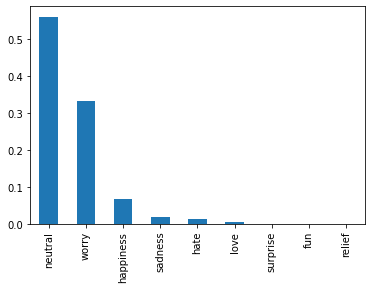

In [13]:
pred_dl = dls_clas.test_dl(covid_tweet['text'])
preds = learn.get_preds(dl=pred_dl)
# Get predicted sentiment
covid_tweet['emo'] = preds[0].argmax(dim=-1)
covid_tweet['emo'] = covid_tweet['emo'].map({0:'anger', 1:'boredom', 2:'enthusiasm', 3:'fun', 4:'happiness', 5:'hate', 6:'love', 7:'neutral', 8:'relief', 9:'sadness', 10:'surprise', 11:'worry'})

# Save to csv
covid_tweet.to_csv(os.path.join(path, 'covid_tweet_sentiment_emo.csv'))

# Plot sentiment value counts
covid_tweet['emo'].value_counts(normalize=True).plot.bar();